# Deep Recurrent Learning (N-BEATS) vs. Traditional Machine Learning
## Advanced Machine Learning in Finance - Individual Project

The aim of this project is to compare the performance of two machine learning models, N-Beats and XGBoost, for predicting sales figures. The challenge is to use available data that has a correlation with the sales of various companies, such as credit card transactions to predict the quarterly sales figures.

The goal is to compare the accuracy of predictions for the current quarter, as well as the next couple of quarters, between N-Beats and XGBoost.

N-Beats is a deep learning model designed specifically for time-series forecasting, while XGBoost is a popular tree-based model used for various types of predictive modeling. This project aim to give insights into comparative forecasting results from these two models and their applications in the field of sales prediction.

The outcome of this project will be a comparison between the two models, including a discussion of the results and their implications for businesses and organizations looking to improve their financial forecasting capabilities.

In [1]:
import darts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch 
import os
import sys
import sklearn 
import torch
from utils import DataFrameProcessor, ModelPipeline
import utils
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts import TimeSeries
import darts.metrics as metrics
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

# Data Extraction

In [2]:
processor = DataFrameProcessor('exabel_data')

In [3]:
# / TODO add covid data as it may be a strong covariate for the time series at question
processor.files

['revenue.xlsx', '.DS_Store', 'covid_us.csv', 'spend_amounts_aggregated.xlsx']

In [4]:
revenue = processor.create_df(processor.revenue)
spendings = processor.create_df(processor.spendings)
df = processor.merge_spendings_revenue(spendings, revenue)
df = processor.create_stationary_covariates(df)
# df = processor.add_war_to_df(df)
df = processor.encode_index(df)
df = processor.remove_small_tickers(df)
df = processor.remove_missing_ground_truth(df)

## Data Exploration

In [5]:
df.columns

Index(['mic', 'ticker', 'time', 'nw_total_sales_a_total',
       'nw_total_sales_b_total', 'Sales_Actual_fiscal',
       'Sales_Estimate_fiscal', 'year', 'month', 'quarter'],
      dtype='object')

In [6]:
# total number of companies
len(df['ticker'].unique())

228

In [7]:
df.isna().sum()

mic                        17
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    709
Sales_Actual_fiscal        58
Sales_Estimate_fiscal      91
year                        0
month                       0
quarter                     0
dtype: int64

#### Inspecting whether seasonality is justified with including data for companies with 10 rows of data (each row correspond to a fiscal quarter)

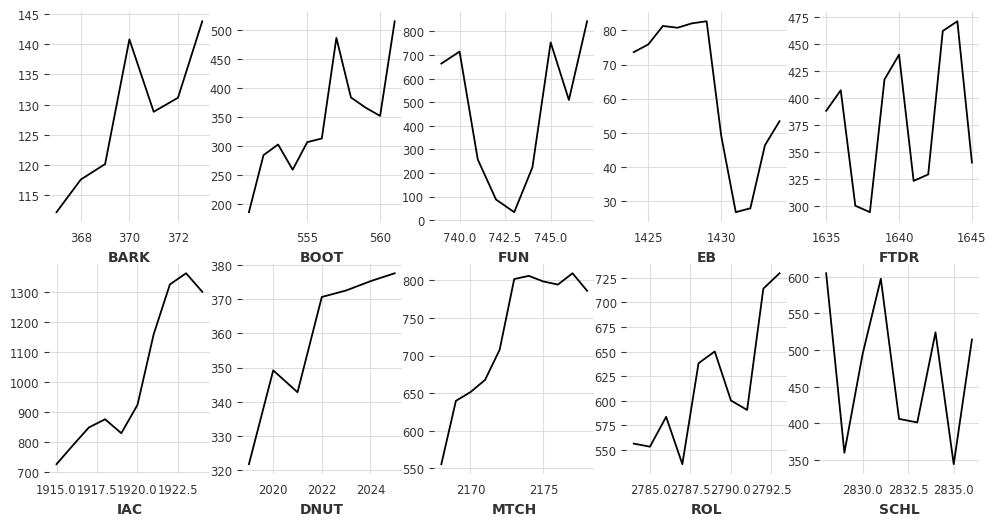

In [8]:
i, j = 0, 0
fig, ax = plt.subplots(2, 5, figsize=(12,6))

for tic in df['ticker'].unique():
    df_copy = df[df['ticker'] == tic]
    if df_copy.shape[0] < 12:
        ax[i][j].plot(df_copy['Sales_Actual_fiscal'])
        ax[i][j].set_xlabel(tic)
        j += 1
        if j == 5:
            j = 0
            i += 1
        if i == 2:
            break
        
plt.show()



In [9]:
processor.print_nans_companies(df)



Ticker: AAL, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AAN, # Data points: 12
Column: Sales_Actual_fiscal, NaN Indices: [0, 1]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2]


Ticker: AAP, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 3]


Ticker: AAPL, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: ACI, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]
Column: Sales_Actual_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6]


Ticker: AD, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 3]


Ticker: ADBE, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEO, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEP, # Data points: 14
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

We see that the vast majority of missing vals are happening in the column 'nw_total_sales_b_total' for the indices in some form of subset of [0,1,2,3] so that it makes sense to impute these values to avoid missing large amounts of data.

/Users/eirikbaekkelund/Desktop/UCL/Code/FinanceTradingApps/project_adv_ml/utils.py:476: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr(), fignum=f.number)


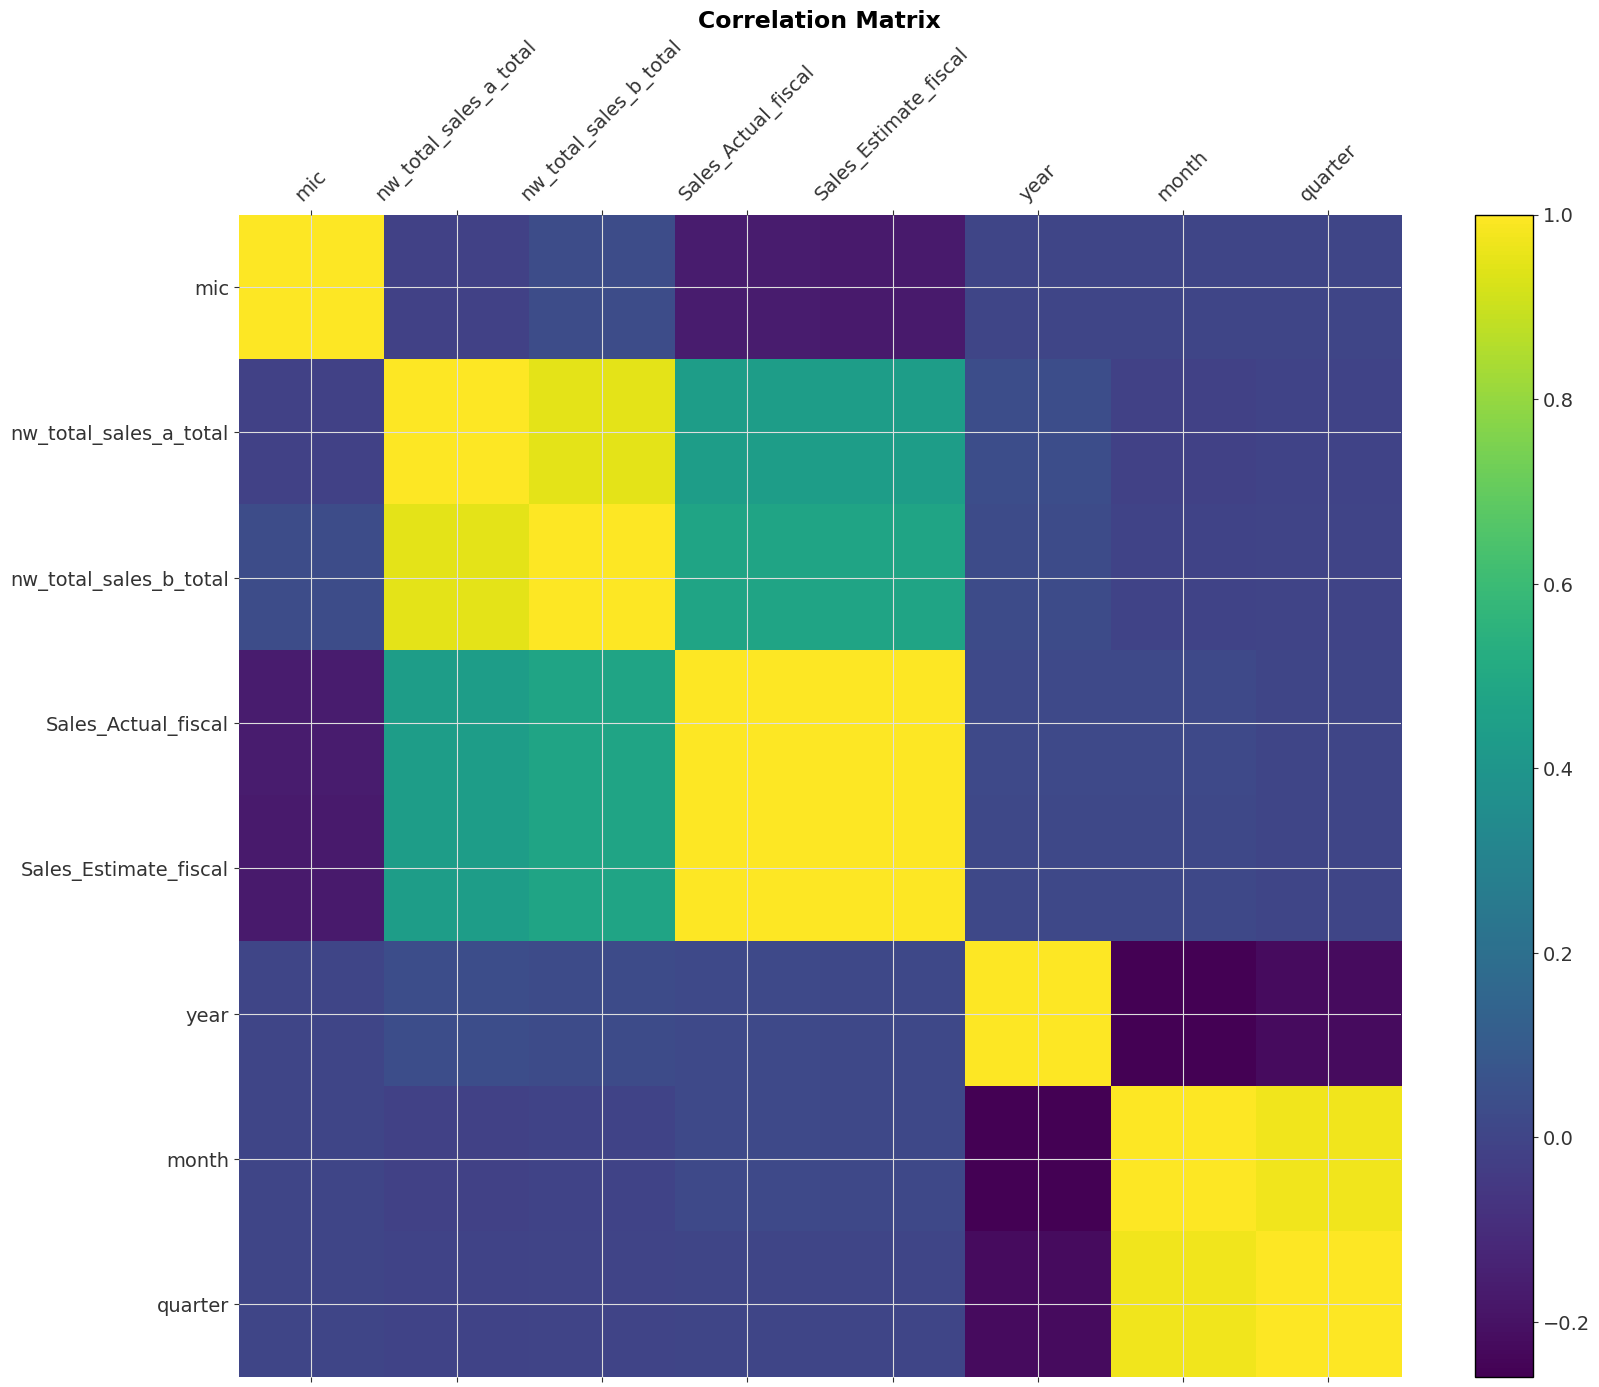

In [10]:
utils.correlation_matrix(df);

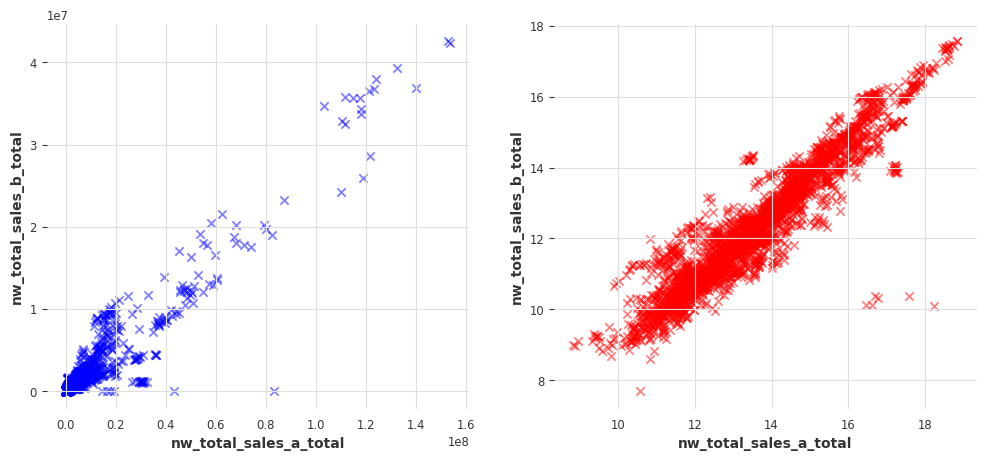

In [11]:
utils.plot_scatter_log(df,'nw_total_sales_a_total', 'nw_total_sales_b_total')

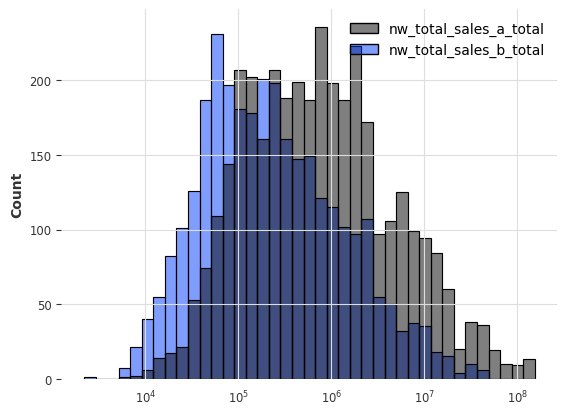

In [12]:
utils.histplot(df, 'nw_total_sales_a_total','nw_total_sales_b_total' )


We see that the distributions are quite similar but shifted, and that they have a fairly linear relationship when we apply the log. Thus, a linear least squares approach is justified. Including the other columns give a higher degree of freedom, but it could be justified to just use these columns up against each other.

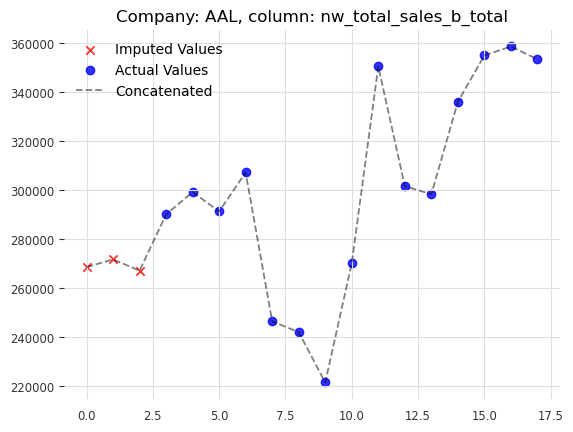

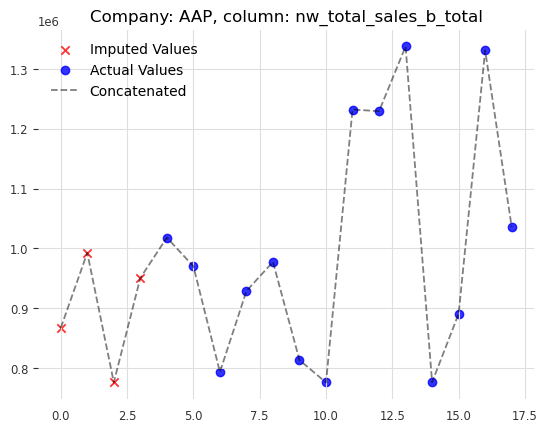

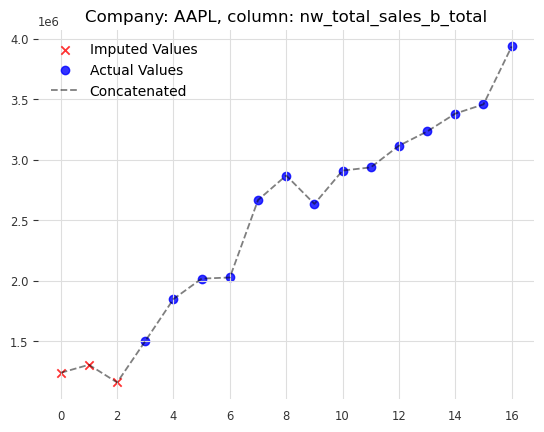

In [13]:
df = processor.impute_nans_singular_column(df, col='nw_total_sales_b_total' ,plot=True, max_plots=3)

Based on the plots a LLS solution looks sensible to the following time series, and thus handles many of the missing datapoints. The accuracy of these are however unknown. Bayesian regression can be performed to quantify uncertainty on the imputation on the missing values. To avoid noisy inputs, one could also perform lasso/ridge regression to shrink mutual information features and reduce high variance issues.   

In [14]:
df.isna().sum()

mic                        17
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    192
Sales_Actual_fiscal        58
Sales_Estimate_fiscal      91
year                        0
month                       0
quarter                     0
dtype: int64

We see that the Actual and Estimated sales for fiscal quarters have a decent amount of NaN values. Thus, we can statistically inspect them as well, and see if there are favorable methods of imputation of these.

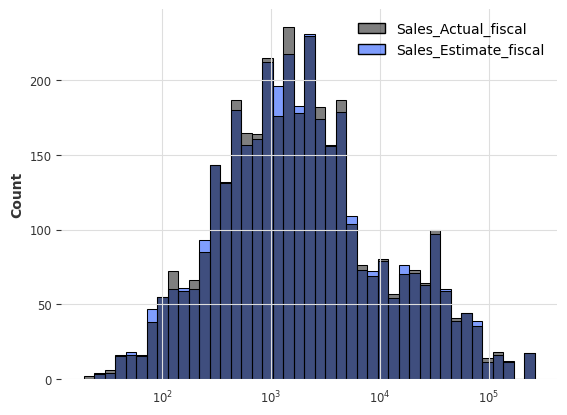

In [15]:
utils.histplot(df, 'Sales_Actual_fiscal', 'Sales_Estimate_fiscal')

The distributions have a very large overlap. Note that the distribution is a concetanation of all companies, so even though this looks normal, it is not necessarily the case for the distribution of actual sales and estimated sales with respect to the company in question.

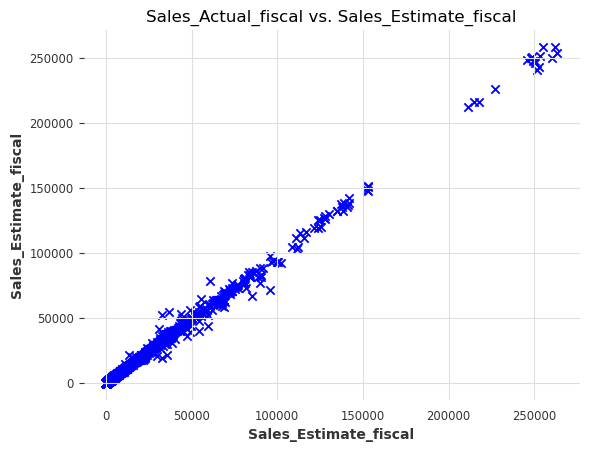

In [16]:
utils.plot_scatter(df, 'Sales_Actual_fiscal', 'Sales_Estimate_fiscal')

From this it looks as they are very linearly correlated. Let's inspect how it looks like for respective companies

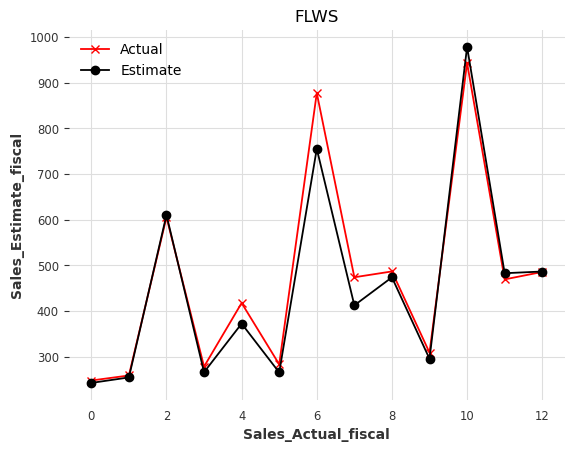

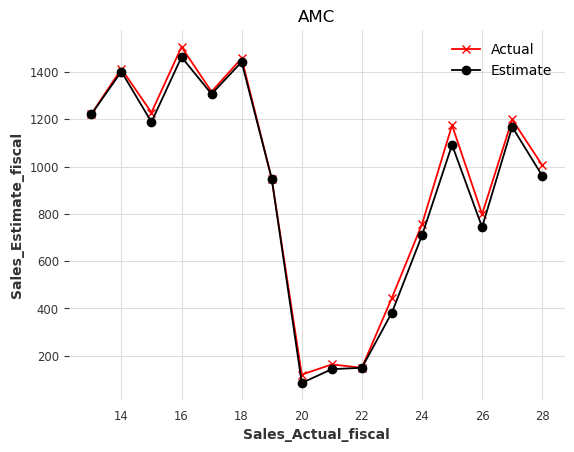

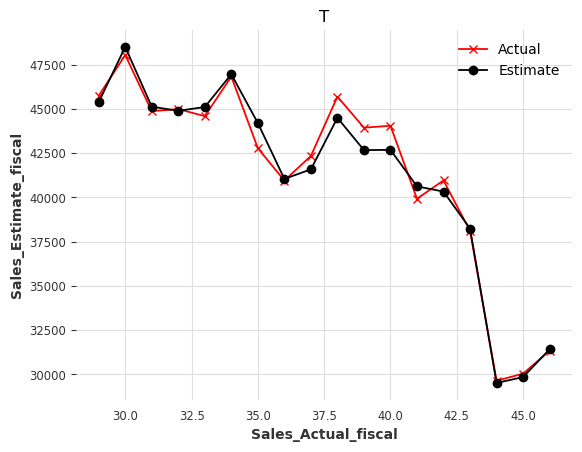

In [17]:
utils.plot_sales_comparison(df, max_plots=3)

It is evident that there are many instances for which the fiscal sales are missing for both estimate and actual, for that reason, we should apply an algorithm that can impute the missing values well. When both have NaNs at the same index over a time span ~5 there are uncertainty with doing rolling averages as there are fluctuations between quarters for many companies. The suggested idea would be to that of a KNN or KD-Ball algorithm to replace these instances. However, for the instances when there are rows when one or the other is present, it makes sense to impute values based on the other. Applying a normal centered at the no NaN column value at the corresponding index with a standard deviation that is the square root of the absolute difference of numeric rows seems like a intuitive and good solution based on their distribution. Also, when there is just a singular column of these with NaN values after doing the computations, we can perform LLS like earlier on those columns, given linearity exists in the dataset for these instances.

In [18]:
df = processor.fiscal_sales_imputation(df, plot=True)

### Remaining NaNs

In [19]:
df.isna().sum()

mic                        17
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    192
Sales_Actual_fiscal         0
Sales_Estimate_fiscal       0
year                        0
month                       0
quarter                     0
dtype: int64

For many of the total sales in A and B these are overlapping. A strategy here could be to use KNN / KD-Balls, Decision Trees or other ML algorithms for imputations

In [20]:
processor.print_nans_companies(df)



Ticker: ACI, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEP, # Data points: 14
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


Ticker: ASO, # Data points: 15
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 6, 7, 8, 11, 12, 14]


Ticker: BARK, # Data points: 9
Column: nw_total_sales_b_total, NaN Indices: [2, 3, 4, 5, 6, 7, 8]


Ticker: BJRI, # Data points: 17
Column: nw_total_sales_a_total, NaN Indices: [7]
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 15]


Ticker: BKE, # Data points: 12
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Ticker: BOOT, # Data points: 11
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Ticker: CAR, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 6, 7, 9]


Ticker: CASY, # Data points: 17
Column: nw_total_sales_a_total, NaN Indices: [2]
Column: nw_total_sa

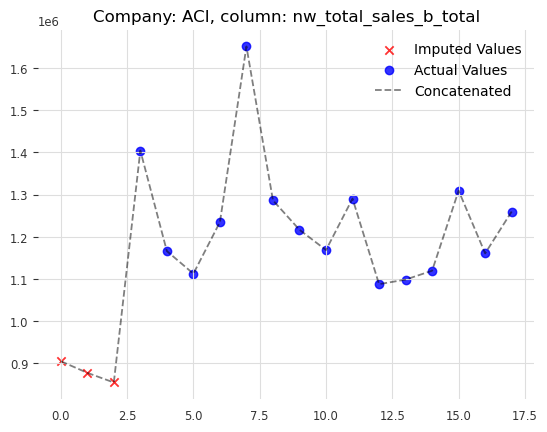

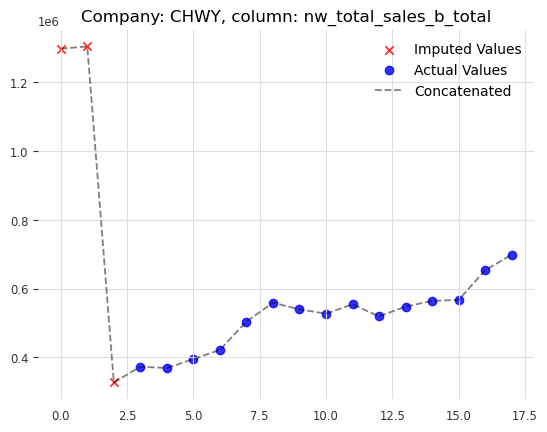

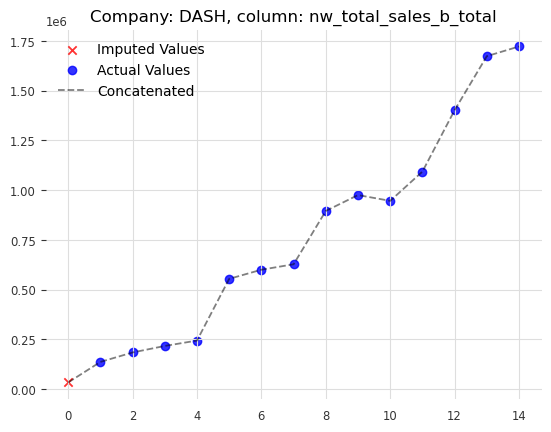

In [21]:
df = processor.impute_nans_singular_column(df, col='nw_total_sales_b_total',plot=True, max_plots=3)

It can seem as this is cause for some anomolies when performing LLS. Let's create a pipeline to detect anomolies.

In [22]:
df.ticker.unique()

array(['FLWS', 'AMC', 'T', 'ANF', 'ASO', 'ATVI', 'ADBE', 'AAP', 'ACI',
       'GOOGL', 'ATUS', 'AMZN', 'AMXL', 'AAL', 'AEO', 'AEP', 'AAPL',
       'ARMK', 'AZO', 'CAR', 'BARK', 'BJRI', 'BJ', 'BP', 'BBWI', 'BBBY',
       'BBY', 'BIG', 'SQ', 'BLMN', 'BKNG', 'BOOT', 'EAT', 'BBW', 'BURL',
       'CVS', 'CAL', 'CTLP', 'CPRI', 'CCL', 'CRI', 'CASY', 'FUN', 'CHTR',
       'CAKE', 'CHGG', 'CVX', 'CHWY', 'CHS', 'CMG', 'CHH', 'CMPR', 'CNK',
       'CTRN', 'CMCSA', 'COP', 'COST', 'CBRL', 'CROX', 'CUBE', 'DISH',
       'DRI', 'PLAY', 'DAL', 'DENN', 'DBI', 'DKS', 'DDS', 'DIN', 'DG',
       'DLTR', 'DPZ', 'DASH', 'DKNG', 'DBX', 'DLTH', 'EA', 'EL', 'ETSY',
       'EB', 'ES', 'EXPE', 'EXPR', 'XOM', 'FDX', 'FIVE', 'FVRR', 'FLTR',
       'FL', 'FTV', 'FRG', 'FTDR', 'ULCC', 'GME', 'GPS', 'GEN', 'GM',
       'GCO', 'GPC', 'GDDY', 'GRPN', 'HOG', 'HLF', 'HIBB', 'HLT', 'HUM',
       'H', 'IAC', 'INTU', 'JACK', 'JBLU', 'KSS', 'AD', 'DNUT', 'MC',
       'LEVI', 'LYV', 'LOW', 'LYFT', 'M', 'MPC', 'MAR', 'MTCH', '

<AxesSubplot: xlabel='month', ylabel='Sales_Actual_fiscal'>

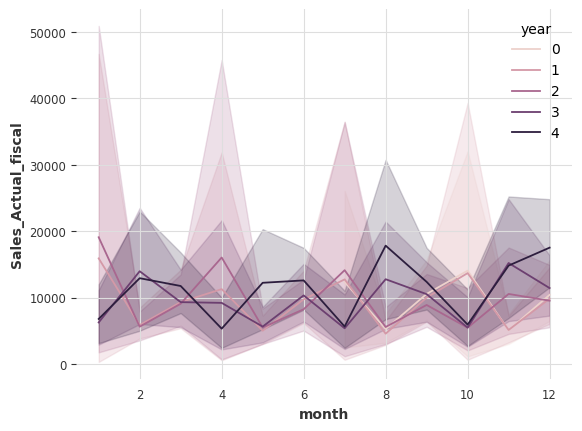

In [23]:
sns.lineplot(data=df, x='month', y='Sales_Actual_fiscal', hue='year')

The lower years observed here are 2021 and 2022 (data starts in 2018), thus it will make sense that we see the hit the economy took

In [24]:
def impute_nans_singular_column(df, proportion = 0.35, plot=False, max_plots=10):
    """ 
    
    """
    assert max_plots <= df.shape[0], "cannot generate more plots than datapoints"
    
    nan_companines = processor.get_nan_columns(df)
    n_plots = 0
    
    for tic, column_list in nan_companines.items():
        if len(column_list) == 1:
            df_copy, original_indices, nan_indices = processor.get_nan_indices(df, tic, col=column_list[0])
            if len(nan_indices) / len(original_indices) <= proportion:
                df = processor.least_square_imputation(df, df_copy, tic, original_indices, col=column_list[0],plot=plot)
                n_plots += 1
                if n_plots == max_plots:
                    plot = False
    return df
df = impute_nans_singular_column(df)

In [25]:
df = processor.remove_missing_ground_truth(df)

# Scaling Data
Now, we have large discrepencies between the values for each column. Thus, it makes sense to normalize them and rather scale up after making predictions. 

### After Scaling
We can start by defining columns that can unveil underlying correlations. In doing so, we allow the network to find complex patterns within the data that otherwise would not have been unveiled

In [26]:
df = df.dropna(how='any')
df = processor.remove_missing_ground_truth(df)
df.shape

(3468, 10)

In [27]:
def min_max_scaler(df):
    for tic in df.ticker.unique():
        df_copy = df[df.ticker == tic].copy()

        for col in ['nw_total_sales_a_total','nw_total_sales_b_total', 'Sales_Actual_fiscal','Sales_Estimate_fiscal']:
            df_copy[col] =  (df_copy[col] - np.min(df_copy[col])) / (np.max(df_copy[col]) - np.min(df_copy[col]))
            df.loc[df.ticker == tic, col] = df_copy[col]

    return df


df = min_max_scaler(df)

In [28]:
df.describe()

,mic,nw_total_sales_a_total,nw_total_sales_b_total,Sales_Actual_fiscal,Sales_Estimate_fiscal,year,month,quarter
count,3468.000000,3466.000000,3466.000000,3466.000000,3466.000000,3468.000000,3468.000000,3468.000000
mean,3.541234,0.457269,0.472965,0.498625,0.488829,2.217128,7.220300,2.586505
std,0.702113,0.308500,0.307255,0.314936,0.316217,1.287098,3.353927,1.098423
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3.000000,0.196545,0.214590,0.223049,0.213390,1.000000,4.000000,2.000000
50%,4.000000,0.431014,0.464301,0.509349,0.494690,2.000000,7.000000,3.000000
75%,4.000000,0.702832,0.716318,0.760865,0.751416,3.000000,10.000000,4.000000
max,7.000000,1.000000,1.000000,1.000000,1.000000,4.000000,12.000000,4.000000


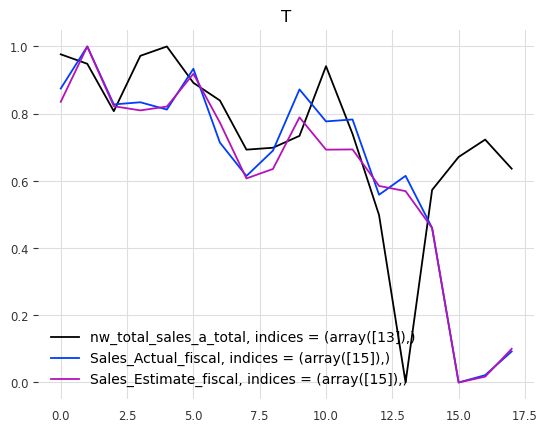

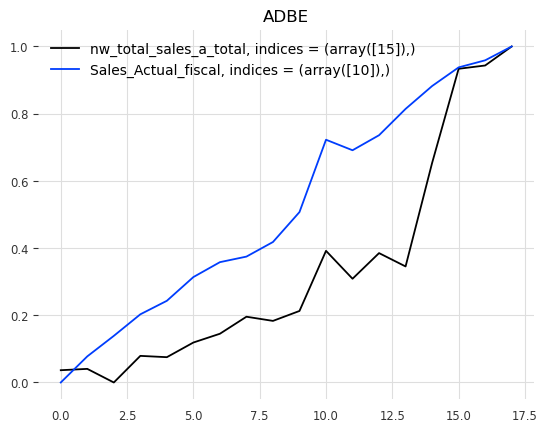

In [29]:
def anamoly_detection(df, plot=False, max_plots=10):
    assert max_plots <= len(df.ticker.unique()), "cannot print more arrays than there are tickers"
    
    def detect_anomaly_ewma(timeseries):
        """ 
        
        """
        span = len(timeseries)
        timeseries = pd.Series(timeseries)
        average = timeseries.ewm(span=span).mean()
        residual = timeseries - average
        
        return np.where(np.abs(residual) > 3 * residual.std(), 1, 0)

    n_plots = 0
    
    for tic in df.ticker.unique():
        df_anomoly = df[df.ticker == tic]
        n_anamolies = 0
        for col in ['nw_total_sales_a_total','nw_total_sales_b_total','Sales_Actual_fiscal','Sales_Estimate_fiscal']:
            anamolies = detect_anomaly_ewma(df_anomoly[col])
            if 1 in list(anamolies) and plot:
                plt.plot(range(df_anomoly.shape[0]) ,df_anomoly[col], label= f"{col}, indices = {np.where(anamolies == 1)}")
                n_anamolies += 1
        if n_anamolies >= 1 and plot:
            plt.title(f"{tic}")
            plt.legend(loc='best')
            plt.show()
            
            n_plots += 1
        if n_plots == max_plots and plot:
            break

anamoly_detection(df, plot=True, max_plots=2)

In [30]:
def add_abs_difference(df):
    """ 
    
    """
    df['abs_diff_sales'] = np.abs(df['Sales_Actual_fiscal'] - df['Sales_Estimate_fiscal'])
    df['abs_diff_costumers'] = np.abs(df['nw_total_sales_a_total'] - df['nw_total_sales_b_total'])
    return df

def add_products(df):
    """ 
    
    """
    df['prod_sales'] = df['Sales_Actual_fiscal'] * df['Sales_Estimate_fiscal']
    df['prod_n_customers'] = df['nw_total_sales_a_total'] * df['nw_total_sales_b_total']
    return df

df = add_abs_difference(df)
df = add_products(df)
df.shape

(3468, 14)

In [31]:
df.describe()

,mic,nw_total_sales_a_total,nw_total_sales_b_total,Sales_Actual_fiscal,Sales_Estimate_fiscal,year,month,quarter,abs_diff_sales,abs_diff_costumers,prod_sales,prod_n_customers
count,3468.000000,3466.000000,3466.000000,3466.000000,3466.000000,3468.000000,3468.000000,3468.000000,3466.000000,3466.000000,3466.000000,3466.000000
mean,3.541234,0.457269,0.472965,0.498625,0.488829,2.217128,7.220300,2.586505,0.057922,0.173352,0.338105,0.279979
std,0.702113,0.308500,0.307255,0.314936,0.316217,1.287098,3.353927,1.098423,0.084484,0.179759,0.319984,0.285759
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.196545,0.214590,0.223049,0.213390,1.000000,4.000000,2.000000,0.008528,0.043671,0.046453,0.038180
50%,4.000000,0.431014,0.464301,0.509349,0.494690,2.000000,7.000000,3.000000,0.028934,0.116618,0.247995,0.187681
75%,4.000000,0.702832,0.716318,0.760865,0.751416,3.000000,10.000000,4.000000,0.076002,0.241854,0.561242,0.448823
max,7.000000,1.000000,1.000000,1.000000,1.000000,4.000000,12.000000,4.000000,1.000000,1.000000,1.000000,1.000000


/Users/eirikbaekkelund/Desktop/UCL/Code/FinanceTradingApps/project_adv_ml/utils.py:476: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr(), fignum=f.number)


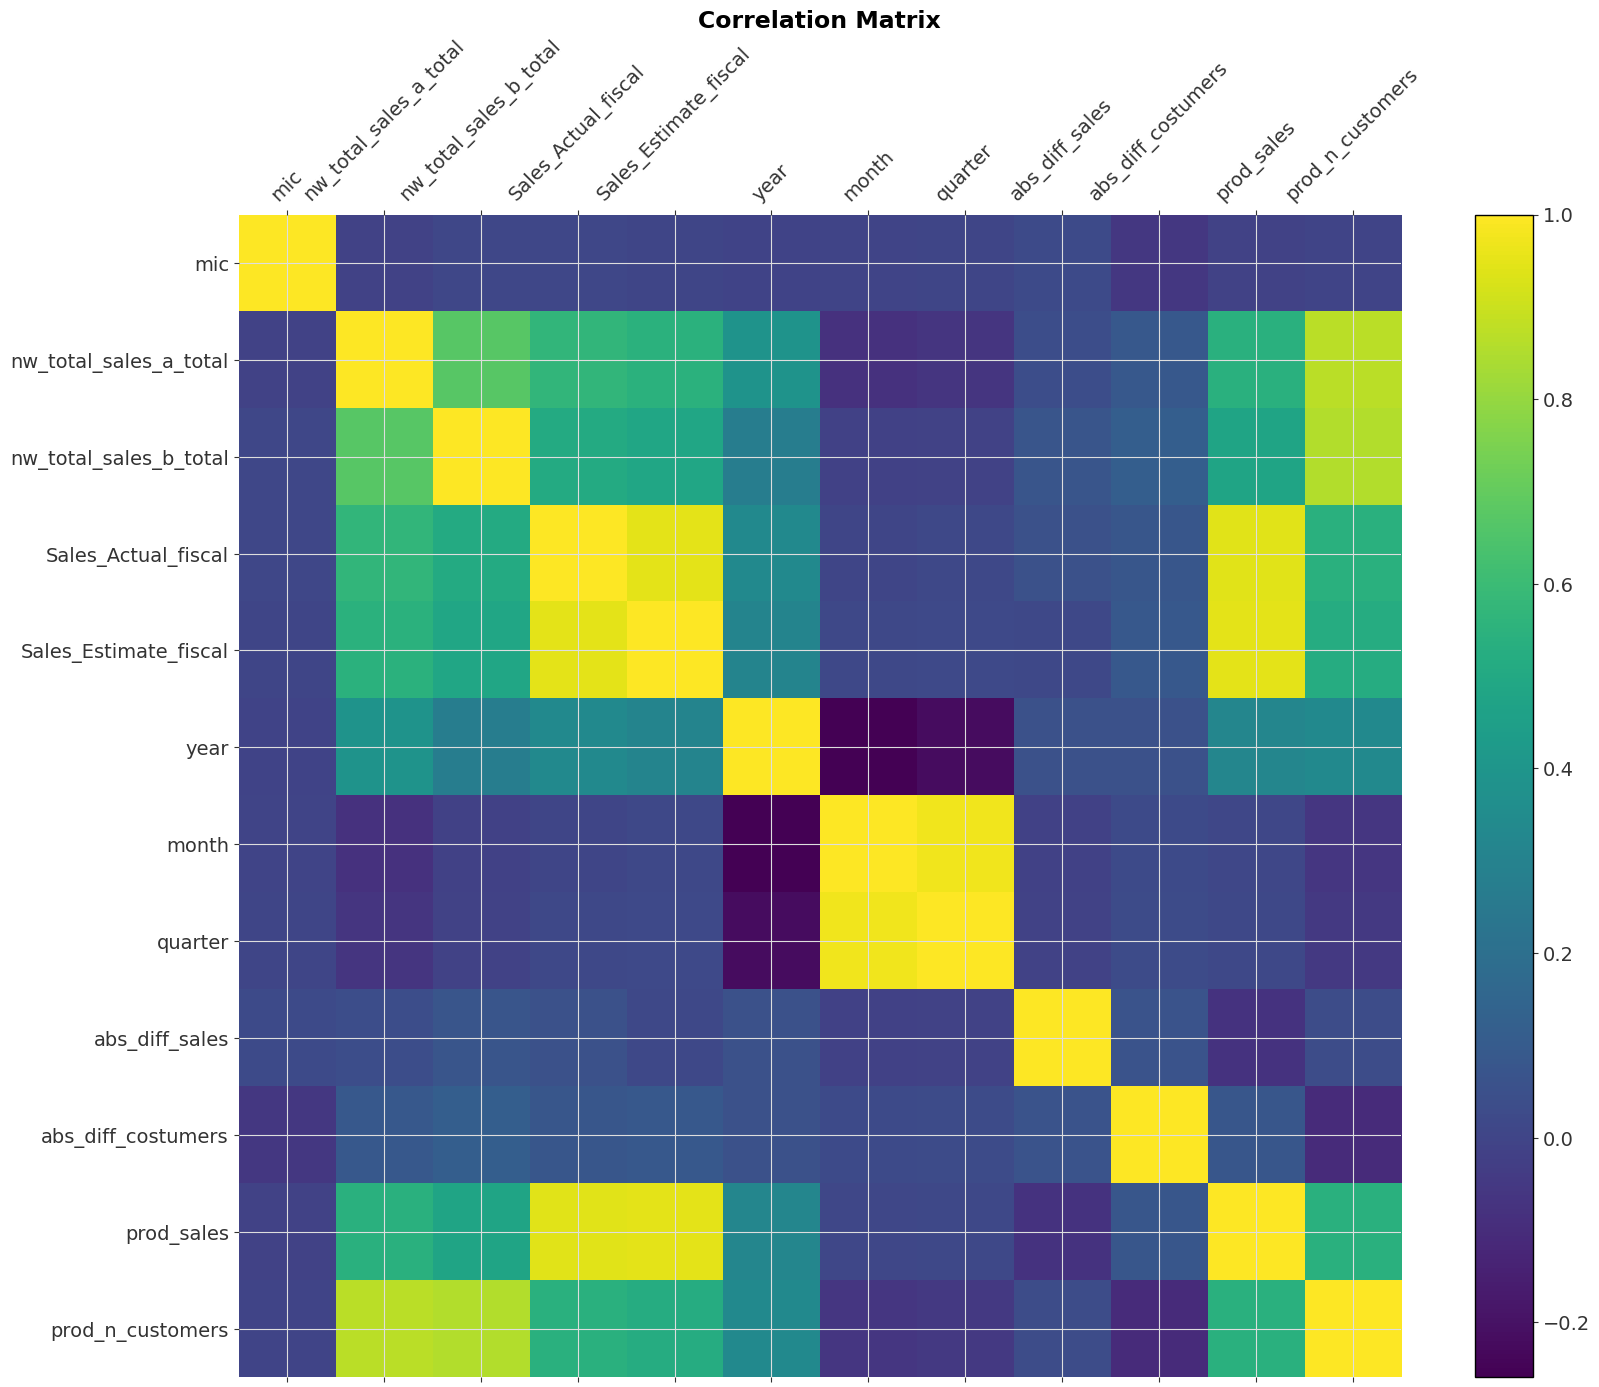

In [32]:
utils.correlation_matrix(df)

# Building Series from Darts

In [33]:
df.columns

Index(['mic', 'ticker', 'time', 'nw_total_sales_a_total',
       'nw_total_sales_b_total', 'Sales_Actual_fiscal',
       'Sales_Estimate_fiscal', 'year', 'month', 'quarter', 'abs_diff_sales',
       'abs_diff_costumers', 'prod_sales', 'prod_n_customers'],
      dtype='object')

In [34]:
# df = model.set_df_index(df)
df.index


Int64Index([   4,    6,    7,    8,   11,   12,   13,   14,   15,   16,
            ...
            3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008],
           dtype='int64', length=3468)

In [35]:
model = ModelPipeline(df)

In [37]:
df = model.set_df_index(df)
df.columns

Index(['mic', 'nw_total_sales_a_total', 'nw_total_sales_b_total',
       'Sales_Actual_fiscal', 'Sales_Estimate_fiscal', 'year', 'month',
       'quarter', 'abs_diff_sales', 'abs_diff_costumers', 'prod_sales',
       'prod_n_customers'],
      dtype='object')

In [36]:
series_dict = model.get_covs_target_dict(df)

KeyError: "['is_war'] not in index"

In [ ]:
covariates_list, series_list = [], []
for key, val in series_dict.items():
    covariates_list.append(series_dict[key][0])
    series_list.append(series_dict[key][1])

print(series_dict)

In [ ]:
series_list

In [ ]:
nbeats = NBEATSModel(input_chunk_length=9, output_chunk_length=2, force_reset=True,
    pl_trainer_kwargs={
      "accelerator": "cpu",
      "devices": 1
    }
)
predictor = nbeats.fit(series=series_list, past_covariates=covariates_list)

In [ ]:
predictor.predict(n=1)

In [ ]:
for tic in df['ticker'].unique():
    print(df[df['ticker'] == tic].shape[0])